In [41]:
!pip install pymysql pandas sqlalchemy

In [42]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

# === RDS MySQL Connection Details ===
rds_endpoint = "rm-3ns023t5i1ctk89e5go.mysql.rds.aliyuncs.com"
rds_port = 3306
rds_dbname = 'cleaned_data'
rds_user = 'adminAcc'
rds_pass = 'Test1234'

# === Create SQLAlchemy engine using PyMySQL ===
engine = create_engine(f'mysql+pymysql://{rds_user}:{rds_pass}@{rds_endpoint}:{rds_port}/{rds_dbname}')

In [43]:
df = pd.read_sql("SELECT * FROM cleaned_data", engine)

In [44]:
df.columns

Index(['transaction_id', 'transaction_date', 'transaction_time',
       'transaction_qty', 'store_id', 'product_id', 'day_of_week', 'month',
       'year', 'hour', 'is_public_holiday', 'holiday_name', 'is_weekend',
       'day_of_month', 'week_of_month'],
      dtype='object')

In [45]:
product_info = pd.read_sql("SELECT * FROM product_info", engine)

In [46]:
product_info.columns

Index(['product_id', 'product_detail', 'product_category', 'unit_price'], dtype='object')

In [47]:
# Read both tables
df = pd.read_sql("SELECT * FROM cleaned_data", engine)
product_info = pd.read_sql("SELECT * FROM product_info", engine)

# Merge product metadata into transactional data
df = df.merge(product_info, on='product_id', how='left')

In [48]:
df

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,product_id,day_of_week,month,year,hour,is_public_holiday,holiday_name,is_weekend,day_of_month,week_of_month,product_detail,product_category,unit_price
0,1,2023-01-01,0 days 07:06:11,2,5,32,Sunday,January,2023,07,1,New Year's Day,1,1,1,Ethiopia Rg,Coffee,3.00
1,2,2023-01-01,0 days 07:08:56,2,5,57,Sunday,January,2023,07,1,New Year's Day,1,1,1,Spicy Eye Opener Chai Lg,Tea,3.10
2,3,2023-01-01,0 days 07:14:04,2,5,59,Sunday,January,2023,07,1,New Year's Day,1,1,1,Dark chocolate Lg,Drinking Chocolate,4.50
3,4,2023-01-01,0 days 07:20:24,1,5,22,Sunday,January,2023,07,1,New Year's Day,1,1,1,Our Old Time Diner Blend Sm,Coffee,2.00
4,5,2023-01-01,0 days 07:22:41,2,5,57,Sunday,January,2023,07,1,New Year's Day,1,1,1,Spicy Eye Opener Chai Lg,Tea,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149111,149452,2023-06-30,0 days 20:18:41,2,8,44,Friday,June,2023,20,0,None,0,30,5,Peppermint Rg,Tea,2.50
149112,149453,2023-06-30,0 days 20:25:10,2,8,49,Friday,June,2023,20,0,None,0,30,5,English Breakfast Lg,Tea,3.00
149113,149454,2023-06-30,0 days 20:31:34,1,8,45,Friday,June,2023,20,0,None,0,30,5,Peppermint Lg,Tea,3.00
149114,149455,2023-06-30,0 days 20:57:19,1,8,40,Friday,June,2023,20,0,None,0,30,5,Cappuccino,Coffee,3.75


In [49]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Group to get daily sales quantity per product
daily_sales = (
    df.groupby(['transaction_date', 'product_id'], as_index=False)['transaction_qty']
    .sum()
    .rename(columns={'transaction_qty': 'daily_qty_sold'})
)

In [50]:
daily_sales

,transaction_date,product_id,daily_qty_sold
0,2023-01-01,22,15
1,2023-01-01,23,21
2,2023-01-01,24,18
3,2023-01-01,25,23
4,2023-01-01,26,14
...,...,...,...
12127,2023-06-30,78,19
12128,2023-06-30,79,12
12129,2023-06-30,83,6
12130,2023-06-30,84,23


In [51]:
# Select relevant time and holiday features (unique per date-product)
temporal_features = df.drop_duplicates(subset=['transaction_date', 'product_id'])[
    ['transaction_date', 'product_id', 'day_of_week', 'month', 'year', 'is_public_holiday', 'is_weekend']
]

# Join with daily sales
model_df = (
    daily_sales
    .merge(temporal_features, on=['transaction_date', 'product_id'], how='left')
    .merge(product_info, on='product_id', how='left')
)

In [52]:
model_df = model_df.sort_values(['product_id', 'transaction_date'])

# Lag features: sales yesterday
model_df['lag_1'] = model_df.groupby('product_id')['daily_qty_sold'].shift(1)
model_df['rolling_mean_3'] = model_df.groupby('product_id')['daily_qty_sold'].shift(1).rolling(3).mean()
model_df['rolling_std_3'] = model_df.groupby('product_id')['daily_qty_sold'].shift(1).rolling(3).std()

In [54]:
# Drop early rows with NaNs from lag features
model_df = model_df.dropna()

# Predict next day’s sales
X = model_df.drop(columns=['daily_qty_sold', 'transaction_date'])
y = model_df['daily_qty_sold']

In [55]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Step 1: Define features and target
X = model_df.drop(columns=['daily_qty_sold', 'transaction_date'])
y = model_df['daily_qty_sold']

# Step 2: Convert object columns to pandas 'category' dtype
categorical_cols = X.select_dtypes(include='object').columns
for col in categorical_cols:
    X[col] = X[col].astype('category')

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

# Step 4: Initialize LightGBM with categorical feature awareness
model = lgb.LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    categorical_feature=categorical_cols.tolist(),
)

# Step 5: Evaluate
preds = model.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
print(f"RMSE: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 8919, number of used features: 11
[LightGBM] [Info] Start training from score 19.384236
RMSE: 13.2160


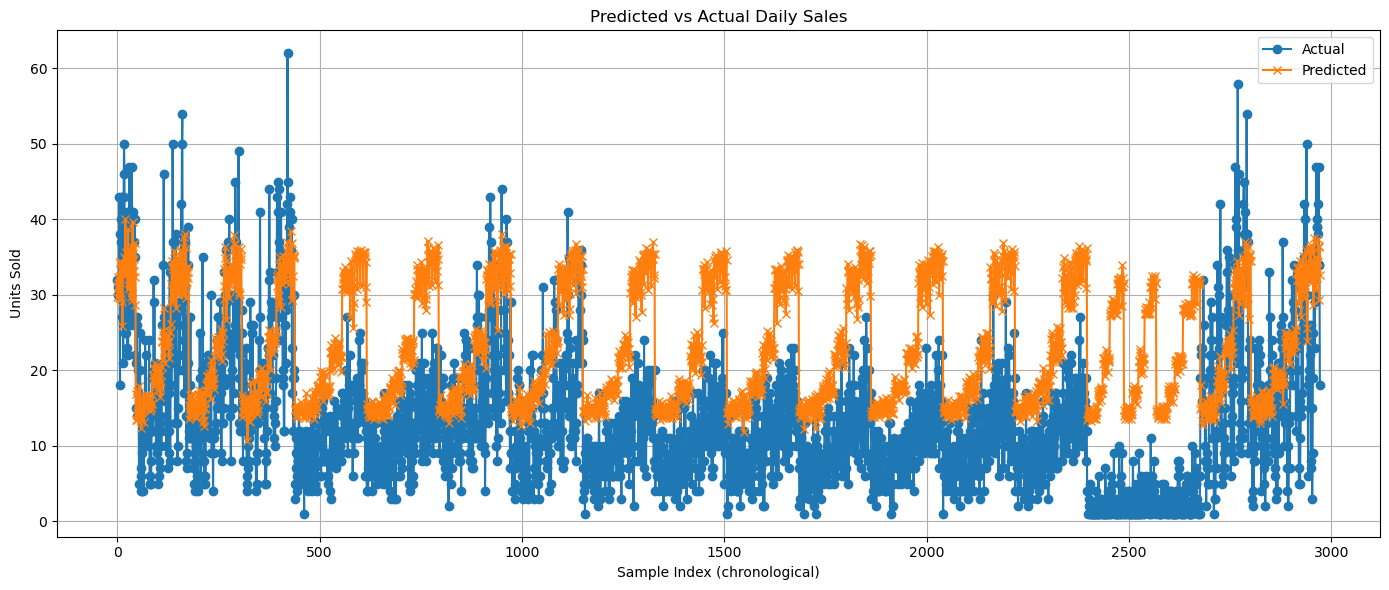

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(preds, label='Predicted', marker='x')
plt.title("Predicted vs Actual Daily Sales")
plt.xlabel("Sample Index (chronological)")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# Convert predictions to Pandas Series (ensure same index as y_test)
preds_series = pd.Series(preds, index=y_test.index, name='predicted_qty_sold')

# Combine into one DataFrame
results_df = pd.concat([
    X_test.reset_index(drop=True),
    y_test.reset_index(drop=True).rename('actual_qty_sold'),
    preds_series.reset_index(drop=True)
], axis=1)

# Round up predictions to nearest integer
results_df['predicted_qty_sold'] = np.ceil(results_df['predicted_qty_sold']).astype(int)

# If actuals aren't integers already (they should be), make them so
results_df['actual_qty_sold'] = results_df['actual_qty_sold'].astype(int)

In [36]:
results_df

,product_id,day_of_week,month,year,is_public_holiday,is_weekend,product_detail,product_category,unit_price,lag_1,rolling_mean_3,rolling_std_3,actual_qty_sold,predicted_qty_sold
0,61,Tuesday,May,2023,0,0,Sustainably Grown Organic Lg,Drinking Chocolate,4.75,52.0,38.000000,12.165525,32,30
1,61,Wednesday,May,2023,0,0,Sustainably Grown Organic Lg,Drinking Chocolate,4.75,32.0,38.000000,12.165525,30,33
2,61,Thursday,May,2023,0,0,Sustainably Grown Organic Lg,Drinking Chocolate,4.75,30.0,38.000000,12.165525,31,32
3,61,Friday,May,2023,0,0,Sustainably Grown Organic Lg,Drinking Chocolate,4.75,31.0,31.000000,1.000000,32,32
4,61,Saturday,May,2023,0,1,Sustainably Grown Organic Lg,Drinking Chocolate,4.75,32.0,31.000000,1.000000,31,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,87,Monday,June,2023,0,0,Ouro Brasileiro shot,Coffee,2.10,42.0,40.000000,1.732051,38,38
2969,87,Tuesday,June,2023,0,0,Ouro Brasileiro shot,Coffee,2.10,38.0,39.666667,2.081666,47,37
2970,87,Wednesday,June,2023,0,0,Ouro Brasileiro shot,Coffee,2.10,47.0,42.333333,4.509250,34,30
2971,87,Thursday,June,2023,0,0,Ouro Brasileiro shot,Coffee,2.10,34.0,39.666667,6.658328,34,37


In [37]:
import joblib
joblib.dump(model, 'sales_forecast_model.pkl')

['sales_forecast_model.pkl']

In [56]:
import joblib
joblib.dump(categorical_cols.tolist(), "categorical_columns.pkl")

['categorical_columns.pkl']

In [38]:
import joblib
joblib.dump(X_train.columns.tolist(), 'model_feature_columns.pkl')

['model_feature_columns.pkl']

In [40]:
X_train.columns.tolist()

['product_id',
 'day_of_week',
 'month',
 'year',
 'is_public_holiday',
 'is_weekend',
 'product_detail',
 'product_category',
 'unit_price',
 'lag_1',
 'rolling_mean_3',
 'rolling_std_3']